# **Comparison between Glasma and Langevin for charm and beauty quarks**

Default simulation parameters chosen for a Glasma formed in $\mathrm{PbPb}$ collisions at $5.02\,\mathrm{TeV}$. 

In [1]:
import numpy as np

# General parameters
su_group = 'su3'        # Gauge group

# Simulation box parameters
L = 10.0      # Length of simulation box [fm]
N = 512   # Number of lattice sites
tau_s = 0.5     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters for Pb-Pb at 5.02 TeV
A = 207     # Mass number
sqrts = 5020        # Center-of-mass energy [GeV]
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)         # Saturation momentum [GeV]	
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.275      # Heavy quark mass [GeV]
tau_form = 0.06     # Formation time [fm/c]
initialization = 'fonll'      # Toy initialization with the same pT or FONLL
pT = 5.0    # Initial transverse momentum [GeV]
ntp = 100000   # Number of test particles

# Other numerical parameters
nevents = 10    # Number of Glasma events

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,       
    'initialization' : initialization,   
    'NTP' : ntp,
    }

Set environment variables.

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.DEBUG = False
wong.REPRESENTATION = 'fundamental'
wong.BOUNDARY = 'periodic'
from curraun.wong import init_charge

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(3)
Unknown representation
Using double precision
Using double precision


Simulation function.

In [3]:


def simulate(p, ev): 
    output = {}
    output['parameters'] = p.copy()

    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_s / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    if initialization=='fonll':
        pTs_fonll, ntp_fonll = initial_momenta_fonll(p)
        ntp = ntp_fonll

    if initialization=='toy':
        pT = p['PT'] / E0
        ntp = p['NTP']

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)

    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)
        
    for i in range(ntp):
        # Positions
        xT = np.random.rand(2) * s.n
        x0 = [xT[0], xT[1], 0.0]
        angle = 2*np.pi*np.random.rand(1)
        # Momenta
        if initialization=='toy':
            p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
            p0s[i, :] = p0
        elif initialization=='fonll':
            pT = pTs_fonll[i] / E0
            p0s[i, :] = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], q0s[i, :] = x0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)

    ps = np.zeros((maxt-formt, ntp, 4))
    pts = np.zeros((maxt-formt, ntp))

    if use_cuda:
        s.copy_to_device()
        wong_solver.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                pmu = wong_solver.p.copy()
                ps[t-formt] = pmu
                pts[t-formt] = np.sqrt(pmu[:, 1] ** 2 + pmu[:, 2] ** 2) * E0

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    sigmapts = []
    for i in range(ntp):
        sigmapt = (ps[:, i, 1]-ps[0, i, 1])**2 + (ps[:, i, 2]-ps[0, i, 2])**2
        sigmapts.append(sigmapt)
    units = E0 ** 2
    sigmapt_mean, sigmapt_std = np.mean(sigmapts, axis=0) * units, np.std(sigmapts, axis=0) / np.sqrt(ntp)

    output['sigmapt_mean'], output['sigmapt_std'] = sigmapt_mean, sigmapt_std
    output['pts'] = pts

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

Simulate over multiple Glasma events and various initial $p_T$ values.

In [4]:
from tqdm import tqdm
import pickle

p['initialization'] = 'toy'

quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]
quark_masses = [1.5, 4]
formation_times = [0.06, 0.02]
pTs = [0.5, 5.0, 10.0]

sigmapt_mean_avg, sigmapt_std_avg, taus = {}, {}, {}
pts, std_pt, pts_tau_stop = {}, {}, {}
parameters = {}

# tau_stop = 0.5

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    # p['TFORM'] = 1/(2*p['MASS'])*hbarc
    p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)

        a = L / N
        DT = 1.0 / DTS
        maxt = int(tau_s / a * DTS)
        formt = int(p['TFORM'] / a * DTS)

        taus[tag] = np.linspace(p['TFORM'], tau_s, maxt-formt)

        # difference_array = np.absolute(taus[tag]-tau_stop)
        # index_tau = difference_array.argmin()

        sigmapts_mean, sigmapts_std = [], []
        pts_events, pts_events_tau_stop = [[] for i in range(maxt-formt+1)], []
        for ev in range(nevents):
            output = simulate(p, ev)
            sigmapts_mean.append(output['sigmapt_mean'])
            sigmapts_std.append(output['sigmapt_std'])
            for i in range(maxt-formt):
                pts_events[i].append(output['pts'][i, :])
            # pts_events_tau_stop.append(output['pts'][index_tau, :])
            pts_events_tau_stop.append(output['pts'][maxt-formt-1, :])

        std = []
        for t in range(maxt-formt):
            std.append(np.std(pts_events[t]))
        # std_pt[tag] = std
        std_pt[tag] = np.square(std)

        sigmapt_mean_avg[tag], sigmapt_std_avg[tag] = np.mean(sigmapts_mean, axis=0), np.mean(sigmapts_std, axis=0)
        parameters[tag] = output['parameters']
        pts[tag], pts_tau_stop[tag] = pts_events, pts_events_tau_stop

results = {}
results['parameters'] = parameters

results['sigmapt_mean'], results['sigmapt_std'] = sigmapt_mean_avg, sigmapt_std_avg
results['std'], results['pts'], results['tau'] = std_pt, pts_tau_stop, taus
results['quarks'], results['pTs'] = quarks, pTs

filename = 'sigmapt_charm_beauty.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(results, handle)

Charm quark
Transverse momentum 0.5 GeV


Event 10: 100%|██████████| 204/204 [00:07<00:00, 28.59it/s]


Transverse momentum 5.0 GeV


Event 10: 100%|██████████| 204/204 [00:07<00:00, 28.60it/s]


Transverse momentum 10.0 GeV


Event 10: 100%|██████████| 204/204 [00:06<00:00, 31.67it/s]


Beauty quark
Transverse momentum 0.5 GeV


Event 10: 100%|██████████| 204/204 [00:07<00:00, 27.25it/s]


Transverse momentum 5.0 GeV


Event 10: 100%|██████████| 204/204 [00:07<00:00, 27.22it/s]


Transverse momentum 10.0 GeV


Event 10: 100%|██████████| 204/204 [00:06<00:00, 33.13it/s]


## FONLL initialization, charm and beauty

In [29]:
from tqdm import tqdm
import pickle

quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]
quark_masses = [1.5, 4]
formation_times = [0.06, 0.02]
# pTs = [0.5, 5.0, 10.0]
p['initialization'] = 'fonll'

sigmapt_mean_avg, sigmapt_std_avg, taus = {}, {}, {}
pts, std_pt, pts_tau_stop = {}, {}, {}
parameters = {}

# tau_stop = 0.3

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    # p['TFORM'] = 1/(2*p['MASS'])*hbarc
    p['TFORM'] = formation_times[iq]

    tag = quarks[iq]

    a = L / N
    DT = 1.0 / DTS
    maxt = int(tau_s / a * DTS)
    formt = int(p['TFORM'] / a * DTS)

    taus[tag] = np.linspace(p['TFORM'], tau_s, maxt-formt)

    # difference_array = np.absolute(taus[tag]-tau_stop)
    # index_tau = difference_array.argmin()

    sigmapts_mean, sigmapts_std = [], []
    pts_events = [[] for i in range(maxt-formt+1)]
    pts_events_tau_stop = np.empty(0)
    for ev in range(nevents):
        output = simulate(p, ev)
        sigmapts_mean.append(output['sigmapt_mean'])
        sigmapts_std.append(output['sigmapt_std'])
        for i in range(maxt-formt):
            pts_events[i].append(output['pts'][i, :])
        # pts_events_tau_stop.append(output['pts'][index_tau, :])
        pts_events_tau_stop = np.append(pts_events_tau_stop, output['pts'][maxt-formt-1, :])

    std = []
    for t in range(maxt-formt):
        std.append(np.std(pts_events[t]))
    # std_pt[tag] = std
    std_pt[tag] = np.square(std)

    sigmapt_mean_avg[tag], sigmapt_std_avg[tag] = np.mean(sigmapts_mean, axis=0), np.mean(sigmapts_std, axis=0)
    parameters[tag] = output['parameters']
    pts[tag], pts_tau_stop[tag] = pts_events, pts_events_tau_stop

results = {}
results['parameters'] = parameters

results['sigmapt_mean'], results['sigmapt_std'] = sigmapt_mean_avg, sigmapt_std_avg
results['std'], results['pts'], results['tau'] = std_pt, pts_tau_stop, taus
results['quarks'] = quarks

filename = 'sigmapt_charm_beauty_fonll.pickle'
# filename = 'sigmapt_charm_beauty_fonll_tau_0.3.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(results, handle)

Charm quark


Event 10: 100%|██████████| 204/204 [00:05<00:00, 34.40it/s]


Beauty quark


Event 10: 100%|██████████| 204/204 [00:06<00:00, 33.16it/s]


## $\mathrm{d}N/\mathrm{d}p_T$ Langevin vs. Glasma for charm and beauty

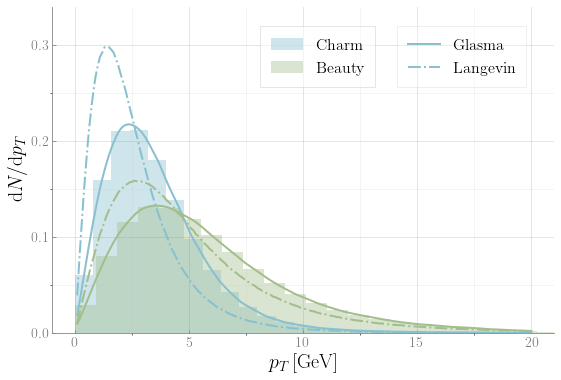

In [31]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import interp1d
from scipy import stats

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
# plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\tau=0.5\,\mathrm{fm/c}$', size = 18)
plt.xlabel(r'$p_T\,\mathrm{[GeV]}$', size = 20)
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}p_T$', size = 20)

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

results = pickle.load(open('sigmapt_charm_beauty_fonll.pickle', 'rb'))
# results = pickle.load(open('sigmapt_charm_beauty_fonll_tau_0.3.pickle', 'rb'))
data_lang = np.loadtxt('langevin_fonll_charm_beauty.dat')
# data_lang = np.loadtxt('langevin_fonll_charm_beauty_tau_0.3.dat')
pTs_lang = data_lang[:, 0]

tags = ["charm", "beauty"]
colors = ['#88C0D0', '#A3BE8C']
labels = [r'$\mathrm{Charm}$', r'$\mathrm{Beauty}$']

i, ilang = 0, 2
for tag in tags:
    n, bins, _ = ax.hist(results['pts'][tag], bins=30, density=True, alpha=0.4, color=colors[i], label=labels[i])  
    # bin_centers = 0.5*(bins[1:]+bins[:-1])

    # bin_interp = np.linspace(bin_centers[0], bin_centers[len(bin_centers)-1], 100)
    # cubic_interp = interp1d(bin_centers, n, kind='cubic')
    # cubic_results = cubic_interp(bin_interp)
    # ax.plot(bin_interp, cubic_results, color=colors[i], linewidth = 2.0, alpha=1.0, label=labels[i])

    density = stats.kde.gaussian_kde(results['pts'][tag])
    ax.plot(pTs_lang, density(pTs_lang), color=colors[i], linewidth = 2.0, alpha=1.0)


    ax.plot(pTs_lang, data_lang[:, ilang], color=colors[i], linewidth=2.0, linestyle='-.')
    i += 1
    ilang += 2

legend1 = ax.legend(fontsize = 16, loc = 'upper right', bbox_to_anchor=(0.65,0.95))
legend1.get_frame().set_boxstyle('square')
legend1.get_frame().set_alpha(0.5)
lines = ax.get_lines()
legend2 = ax.legend([lines[i] for i in [0, 1]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper right', ncol=1, bbox_to_anchor=(0.95,0.95), fontsize=16)
legend2.get_frame().set_boxstyle('square')
legend2.get_frame().set_alpha(0.3)
ax.add_artist(legend1)

ax.set_xlim(-1, 21)
ax.set_ylim(0, 0.34)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))

# plt.tight_layout()
plt.savefig('dndpt_fonll_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)
# plt.savefig('dndpt_fonll_charm+beauty_glasma_vs_langevin_tau_0.3.png', dpi=300, facecolor='white', transparent=False)

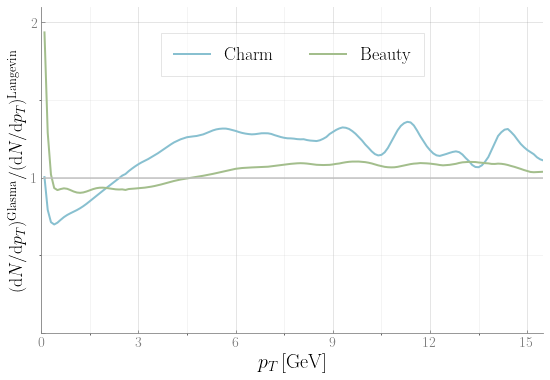

In [32]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import stats
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
# plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\tau=0.5\,\mathrm{fm/c}$', size = 18)
plt.xlabel(r'$p_T\,\mathrm{[GeV]}$', size = 20)
# plt.ylabel(r'$(\mathrm{d}N/\mathrm{d}p_T)^\mathrm{Langevin}/(\mathrm{d}N/\mathrm{d}p_T)^\mathrm{Glasma}$', size = 18)
plt.ylabel(r'$(\mathrm{d}N/\mathrm{d}p_T)^\mathrm{Glasma}/(\mathrm{d}N/\mathrm{d}p_T)^\mathrm{Langevin}$', size = 18)


fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

# results = pickle.load(open('sigmapt_charm_beauty_fonll.pickle', 'rb'))
results = pickle.load(open('sigmapt_charm_beauty_fonll_tau_0.3.pickle', 'rb'))
# data_lang = np.loadtxt('langevin_fonll_charm_beauty.dat')
data_lang = np.loadtxt('langevin_fonll_charm_beauty_tau_0.3.dat')
pTs_lang = data_lang[:, 0]

tags = ["charm", "beauty"]
colors = ['#88C0D0', '#A3BE8C']
labels = [r'$\mathrm{Charm}$', r'$\mathrm{Beauty}$']

i = 0
for tag in tags:
    density = stats.kde.gaussian_kde(results['pts'][tag])
    # ratio = data_lang[:, i+2]/density(pTs_lang)
    # ratio = savgol_filter(data_lang[:, i+2]/density(pTs_lang), 51, 11)
    # ratio = density(pTs_lang)/data_lang[:, i+2]
    ratio = savgol_filter(density(pTs_lang)/data_lang[:, i+2], 51, 11)
    ax.plot(pTs_lang, ratio, color=colors[i], linewidth = 2.0, alpha=1.0)

    # bin_interp = np.linspace(pTs_lang[0], pTs_lang[len(pTs_lang)-1], 100)
    # lang_interp, glasma_interp = interp1d(pTs_lang, data_lang[:, i+2], kind='cubic'), interp1d(pTs_lang, density(pTs_lang), kind='cubic')
    # data_lang_interp, data_glasma_interp  = lang_interp(bin_interp), glasma_interp(bin_interp)
    # ratio = data_lang_interp/data_glasma_interp
    # ax.plot(bin_interp, ratio, color=colors[i], linewidth = 2.0, alpha=1.0)
    i += 1

lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in [0, 1]], labels, loc = 'upper center', ncol=2, bbox_to_anchor=(0.5,0.93), fontsize=18)
legend1.get_frame().set_boxstyle('square')
legend1.get_frame().set_alpha(0.5)
# ax.add_artist(legend1)

ax.plot(pTs_lang, np.ones(len(pTs_lang)), color='silver', linewidth = 1.8, alpha=0.8)

# ax.set_xlim(0, 15)
# ax.set_ylim(-0.5, 2.5)
ax.set_xlim(0, 15.5)
ax.set_ylim(0, 2.1)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(3))
ax.xaxis.set_minor_locator(MultipleLocator(1.5))

# plt.tight_layout()
plt.savefig('replot_ratio_dndpt_fonll_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)
# plt.savefig('ratio_dndpt_fonll_charm+beauty_glasma_vs_langevin_tau_0.3.png', dpi=300, facecolor='white', transparent=False)

## Transverse momentum broadening $\Delta p_T^2$, charm and beauty, Glasma vs. Langevin

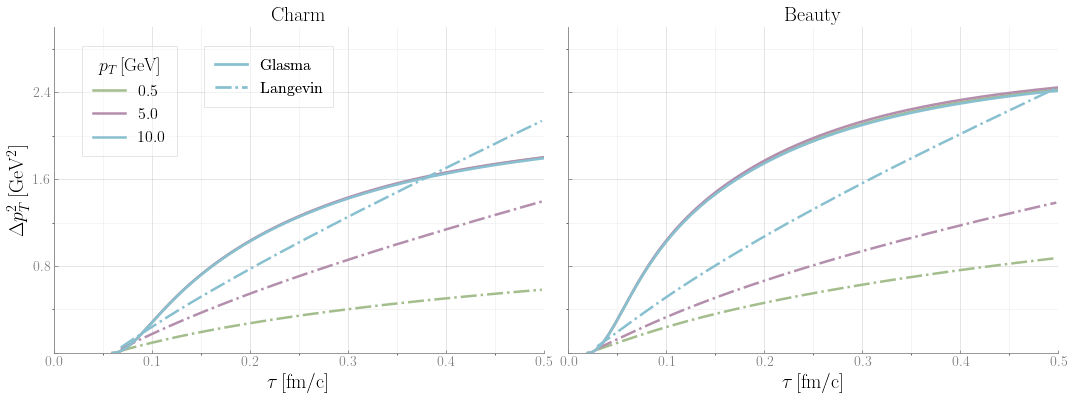

In [39]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
from scipy import signal 

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (18, 6)
plt.rcParams.update({'font.size':14})

fig, ax = plt.subplots(1, 2)

fig.patch.set_facecolor('white')

ax[0].set_ylabel(r'$\Delta p_T^2\,\mathrm{[GeV^2]}$', size = 20)
titles = [r'$\mathrm{Charm}$', r'$\mathrm{Beauty}$']

for i in range(2):
    ax[i].set_title(titles[i], size=20)
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines['bottom'].set_color('gray')
    ax[i].spines['left'].set_color('gray') 
    ax[i].tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
    ax[i].xaxis.grid(True, which='minor')
    ax[i].yaxis.grid(True, which='minor')
    ax[i].grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
    ax[i].grid(b=True, which='minor', color='silver', alpha=0.2)

colors = ['#A3BE8C', '#B48EAD', '#88C0D0']
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

results = pickle.load(open('sigmapt_charm_beauty.pickle', 'rb'))

quarks = ['charm', 'beauty']
ax_quark = 0
for quark in quarks:
    tags = [quark + '_pT_0.5', quark + '_pT_5.0', quark + '_pT_10.0']

    i = 0
    for tag in tags:
        # ax[ax_quark].plot(results['tau'][tag], results['sigmapt_mean'][tag], color=colors[i], linewidth=2.5)
        ax[ax_quark].plot(results['tau'][tag], results['sigmapt_mean'][tag]/3, color=colors[i], linewidth=2.5)
        
        data_lang = np.loadtxt('langevin_' + quark + '_broadening.dat', skiprows=1)
        ax[ax_quark].plot(data_lang[:, 0], data_lang[:, i+1], color=colors[i], linewidth=2.5, linestyle='-.')
        # add origin values
        # tau_lang, broad_lang = np.insert(data_lang[:, 0],0,results['tau'][tag][0]), np.insert(data_lang[:, i+1], 0,0)
        # ax[ax_quark].plot(tau_lang, broad_lang, color=colors[i], linewidth=2.5, linestyle='-.')
        i = i+1
    ax_quark +=1

lines = ax[0].get_lines()
legend1 = ax[0].legend([lines[i] for i in [0,2,4]], labels, loc = 'upper left', ncol=1, bbox_to_anchor=(0.05,0.95), title=r'$p_T\,\mathrm{[GeV]}$', fontsize=16)
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend1.get_frame().set_alpha(0.5)
legend2 = ax[0].legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper left', bbox_to_anchor=(0.3,0.95), fontsize=16)
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
legend2.get_frame().set_alpha(0.3)
ax[0].add_artist(legend1)
ax[0].add_artist(legend2)

for i in range(2):
    ax[i].set_xlim(0, 0.5)
    ax[i].set_ylim(0, 3)
    # ax[i].set_ylim(0, 8)
    ax[i].xaxis.set_major_locator(MultipleLocator(0.1))
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.05))
    ax[i].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax[i].yaxis.set_major_locator(MultipleLocator(0.8))
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.4))

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05, hspace=0)

# plt.tight_layout()
# plt.savefig('momentum_broadening_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)

## Derivative of $\delta p_T^2$ in double-log scale, charm and beauty, Glasma vs. Langevin

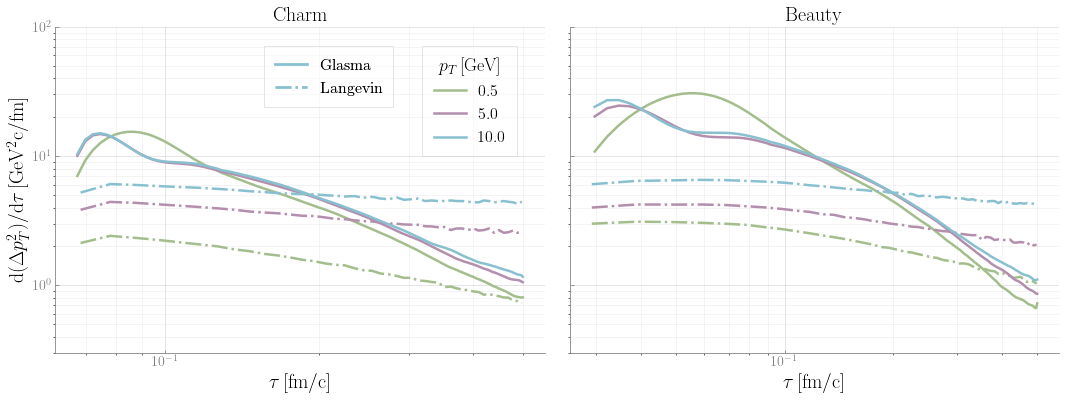

In [33]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
from scipy import signal 

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (18, 6)
plt.rcParams.update({'font.size':14})

fig, ax = plt.subplots(1, 2)

fig.patch.set_facecolor('white')

ax[0].set_ylabel(r'$\mathrm{d}(\Delta p_T^2)/\mathrm{d}\tau\,\mathrm{[GeV^2c/fm]}$', size = 20)
titles = [r'$\mathrm{Charm}$', r'$\mathrm{Beauty}$']

for i in range(2):
    ax[i].set_title(titles[i], size=20)
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines['bottom'].set_color('gray')
    ax[i].spines['left'].set_color('gray') 
    ax[i].tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
    ax[i].xaxis.grid(True, which='minor')
    ax[i].yaxis.grid(True, which='minor')
    ax[i].grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
    ax[i].grid(b=True, which='minor', color='silver', alpha=0.2)

colors = ['#A3BE8C', '#B48EAD', '#88C0D0']
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

results = pickle.load(open('sigmapt_charm_beauty.pickle', 'rb'))

quarks = ['charm', 'beauty']
ax_quark = 0
for quark in quarks:
    tags = [quark + '_pT_0.5', quark + '_pT_5.0', quark + '_pT_10.0']

    i = 0
    for tag in tags:
        data_lang = np.loadtxt('langevin_' + quark + '_broadening.dat', skiprows=1)

        absolute_val_array = np.abs(results['tau'][tag] - data_lang[0, 0])
        index = absolute_val_array.argmin()

        # derivative = np.diff(results['sigmapt_mean'][tag]) / np.diff(results['tau'][tag])
        # ax[ax_quark].plot(results['tau'][tag][1:len(results['tau'][tag])], signal.savgol_filter(derivative, 51, 10), color=colors[i], linewidth=2.5)

        derivative = np.diff(results['sigmapt_mean'][tag][index-1:len(results['tau'][tag])]) / np.diff(results['tau'][tag][index-1:len(results['tau'][tag])])
        ax[ax_quark].plot(results['tau'][tag][index:len(results['tau'][tag])], signal.savgol_filter(derivative, 51, 10), color=colors[i], linewidth=2.5)

        ax[ax_quark].plot(data_lang[:, 0], data_lang[:, i+4], color=colors[i], linewidth=2.5, linestyle='-.')
        i = i+1
    ax_quark +=1

lines = ax[0].get_lines()
legend1 = ax[0].legend([lines[i] for i in [0,2,4]], labels, loc = 'upper right', ncol=1, bbox_to_anchor=(0.95,0.95), title=r'$p_T\,\mathrm{[GeV]}$', fontsize=16)
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend1.get_frame().set_alpha(0.5)
legend2 = ax[0].legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper left', bbox_to_anchor=(0.42,0.95), fontsize=16)
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
legend2.get_frame().set_alpha(0.3)
ax[0].add_artist(legend1)
ax[0].add_artist(legend2)

for i in range(2):
    ax[i].set_ylim(0.3, 100)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    plt.setp(ax[i].get_xminorticklabels(), visible=False)

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05, hspace=0)

# plt.tight_layout()
plt.savefig('derivative_momentum_broadening_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)

## Standard deviation $\sigma_{p_T}^2$ for charm and beauty, Glasma vs. Langevin

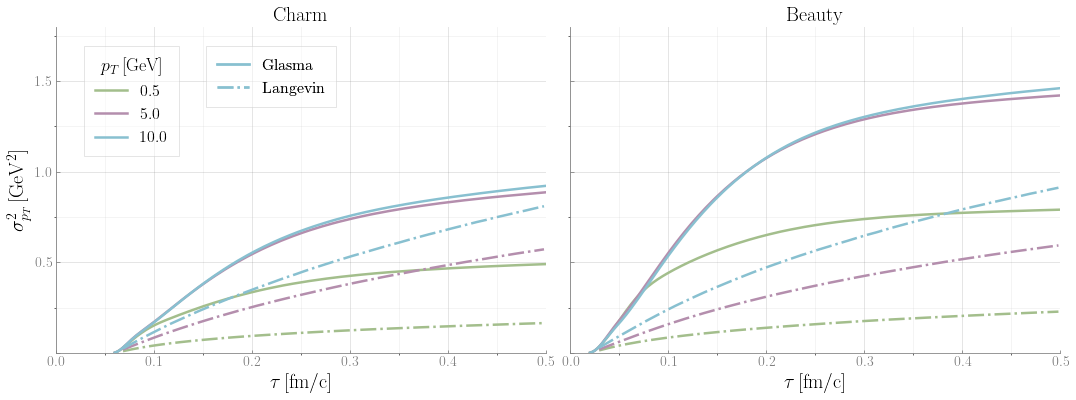

In [39]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
from scipy import signal 

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (18, 6)
plt.rcParams.update({'font.size':14})

fig, ax = plt.subplots(1, 2)

fig.patch.set_facecolor('white')

ax[0].set_ylabel(r'$\sigma_{p_T}^2\,\mathrm{[GeV^2]}$', size = 20)
titles = [r'$\mathrm{Charm}$', r'$\mathrm{Beauty}$']

for i in range(2):
    ax[i].set_title(titles[i], size=20)
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines['bottom'].set_color('gray')
    ax[i].spines['left'].set_color('gray') 
    ax[i].tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
    ax[i].xaxis.grid(True, which='minor')
    ax[i].yaxis.grid(True, which='minor')
    ax[i].grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
    ax[i].grid(b=True, which='minor', color='silver', alpha=0.2)

colors = ['#A3BE8C', '#B48EAD', '#88C0D0']
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

results = pickle.load(open('sigmapt_charm_beauty.pickle', 'rb'))

quarks = ['charm', 'beauty']
ax_quark = 0
for quark in quarks:
    tags = [quark + '_pT_0.5', quark + '_pT_5.0', quark + '_pT_10.0']

    i = 0
    for tag in tags:
        ax[ax_quark].plot(results['tau'][tag], results['std'][tag], color=colors[i], linewidth=2.5)
        
        data_lang = np.loadtxt('langevin_' + quark + '_sigmapt.dat', skiprows=1)
        ax[ax_quark].plot(data_lang[:, 0], data_lang[:, i+7], color=colors[i], linewidth=2.5, linestyle='-.')
        # add origin values
        # tau_lang, sigmapt_lang = np.insert(data_lang[:, 0],0,results['tau'][tag][0]), np.insert(data_lang[:, i+1], 0,0)
        # ax[ax_quark].plot(tau_lang, sigmapt_lang, color=colors[i], linewidth=2.5, linestyle='-.')
        i = i+1
    ax_quark +=1

lines = ax[0].get_lines()
legend1 = ax[0].legend([lines[i] for i in [0,2,4]], labels, loc = 'upper left', ncol=1, bbox_to_anchor=(0.05,0.95), title=r'$p_T\,\mathrm{[GeV]}$', fontsize=16)
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend1.get_frame().set_alpha(0.5)
legend2 = ax[0].legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper left', bbox_to_anchor=(0.3,0.95), fontsize=16)
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
legend2.get_frame().set_alpha(0.3)
ax[0].add_artist(legend1)
ax[0].add_artist(legend2)

for i in range(2):
    ax[i].set_xlim(0, 0.5)
    ax[i].set_ylim(0, 1.8)
    ax[i].xaxis.set_major_locator(MultipleLocator(0.1))
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.05))
    ax[i].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax[i].yaxis.set_major_locator(MultipleLocator(0.5))
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.25))

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05, hspace=0)

# plt.tight_layout()
plt.savefig('standard_deviation_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)

## Derivative of standard deviation for charm and beauty, Glasma vs. Langevin

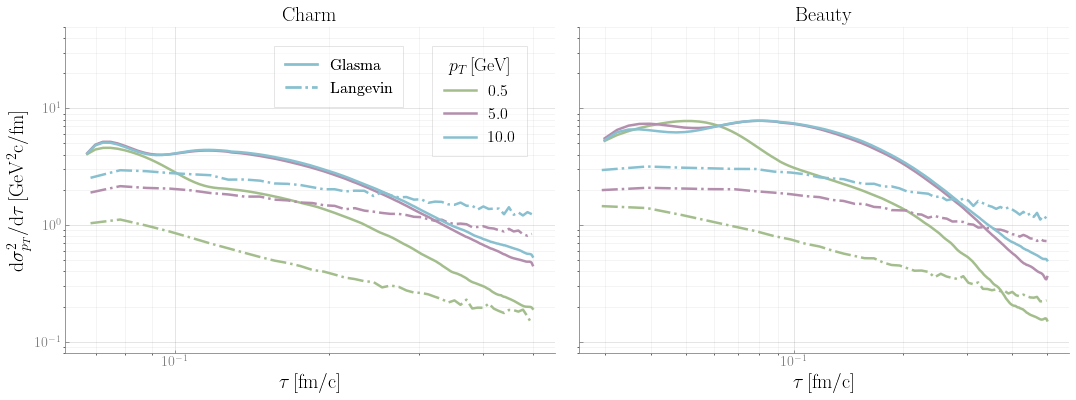

In [38]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
from scipy import signal 

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (18, 6)
plt.rcParams.update({'font.size':14})

fig, ax = plt.subplots(1, 2)

fig.patch.set_facecolor('white')

ax[0].set_ylabel(r'$\mathrm{d}\sigma_{p_T}^2/\mathrm{d}\tau\,\mathrm{[GeV^2c/fm]}$', size = 20)
titles = [r'$\mathrm{Charm}$', r'$\mathrm{Beauty}$']

for i in range(2):
    ax[i].set_title(titles[i], size=20)
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines['bottom'].set_color('gray')
    ax[i].spines['left'].set_color('gray') 
    ax[i].tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
    ax[i].xaxis.grid(True, which='minor')
    ax[i].yaxis.grid(True, which='minor')
    ax[i].grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
    ax[i].grid(b=True, which='minor', color='silver', alpha=0.2)

colors = ['#A3BE8C', '#B48EAD', '#88C0D0']
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

results = pickle.load(open('sigmapt_charm_beauty.pickle', 'rb'))

quarks = ['charm', 'beauty']
ax_quark = 0
for quark in quarks:
    tags = [quark + '_pT_0.5', quark + '_pT_5.0', quark + '_pT_10.0']

    i = 0
    for tag in tags:
        data_lang = np.loadtxt('langevin_' + quark + '_sigmapt.dat', skiprows=1)

        # derivative = np.diff(results['std'][tag]) / np.diff(results['tau'][tag])
        # ax[ax_quark].plot(results['tau'][tag][1:len(results['tau'][tag])], signal.savgol_filter(derivative, 51, 10), color=colors[i], linewidth=2.5)

        absolute_val_array = np.abs(results['tau'][tag] - data_lang[0, 0])
        index = absolute_val_array.argmin()

        derivative = np.diff(results['std'][tag][index-1:len(results['tau'][tag])]) / np.diff(results['tau'][tag][index-1:len(results['tau'][tag])])
        ax[ax_quark].plot(results['tau'][tag][index:len(results['tau'][tag])], signal.savgol_filter(derivative, 51, 10), color=colors[i], linewidth=2.5)

        ax[ax_quark].plot(data_lang[:, 0], data_lang[:, i+10], color=colors[i], linewidth=2.5, linestyle='-.')
        i = i+1
    ax_quark +=1

lines = ax[0].get_lines()
legend1 = ax[0].legend([lines[i] for i in [0,2,4]], labels, loc = 'upper right', ncol=1, bbox_to_anchor=(0.95,0.95), title=r'$p_T\,\mathrm{[GeV]}$', fontsize=16)
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend1.get_frame().set_alpha(0.5)
legend2 = ax[0].legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper left', bbox_to_anchor=(0.42,0.95), fontsize=16)
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
legend2.get_frame().set_alpha(0.3)
ax[0].add_artist(legend1)
ax[0].add_artist(legend2)

for i in range(2):
    ax[i].set_ylim(0.08, 50)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    plt.setp(ax[i].get_xminorticklabels(), visible=False)

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05, hspace=0)

# plt.tight_layout()
plt.savefig('derivative_standard_deviation_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)

## Read data from files using Julia

In [1]:
using Pickle
using DelimitedFiles

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

file = "sigmapt_charm_beauty.pickle"
data_glasma = Pickle.npyload(file)
parameters = data_glasma["parameters"]
sigmapt_mean, sigmapt_std, tau = data_glasma["sigmapt_mean"], data_glasma["std"], data_glasma["tau"]
pts = data_glasma["pts"]
quarks, pTs = data_glasma["quarks"], data_glasma["pTs"]

data_lang_broad, data_lang_sigmapt, data_lang_distrib = Dict(), Dict(), Dict()
for quark in quarks
    data_lang_broad[quark], header = readdlm("langevin_"*quark*"_broadening.dat", header=true)
    data_lang_sigmapt[quark], header = readdlm("langevin_"*quark*"_sigmapt.dat", header=true)
    data_lang_distrib[quark], header = readdlm("langevin_"*quark*"_distrib.dat", header=true)
end


## Plot transverse momentum variance

Momentum broadening $\langle p_T^2\rangle$ Glasma vs. Langevin for charm quark.

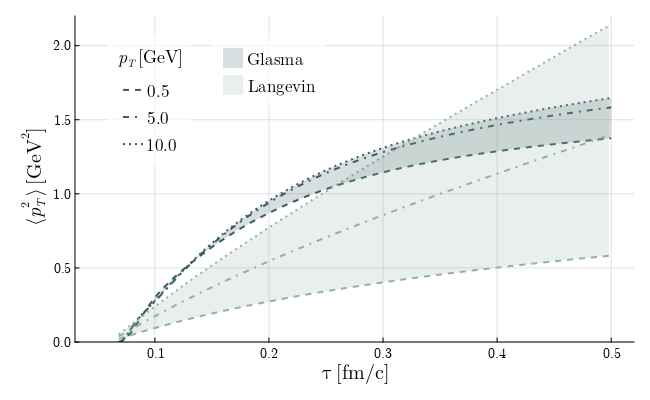

In [2]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle p_T^2\,\rangle\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

iq = 1
for ipT in 1:length(pTs)
    tag_quark_pt = quarks[iq] * "_pT_" * string(pTs[ipT])
    string_as_varname("lineglasmapT"*string(ipT), lines!(ax, tau[tag_quark_pt], sigmapt_mean[tag_quark_pt], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
    string_as_varname("linelangpT"*string(ipT), lines!(ax, data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, ipT+1], linewidth = 2, color=colors[2], linestyle=linestyles[ipT]))
end

tag_quark_pt_first, tag_quark_pt_last = quarks[iq] * "_pT_" * string(pTs[1]), quarks[iq] * "_pT_" * string(pTs[3])
string_as_varname("bandglasma", band!(ax, tau[tag_quark_pt_first], sigmapt_mean[tag_quark_pt_first], sigmapt_mean[tag_quark_pt_last]; color = (colors[1], 0.2)))
string_as_varname("bandlang", band!(ax, data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, 2], data_lang_broad[quarks[iq]][:, 4]; color = (colors[2], 0.2)))

axislegend(ax, [bandglasma, bandlang], [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.3, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [lineglasmapT1, lineglasmapT2, lineglasmapT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.05,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

ylims!(ax, 0, 2.2)
xlims!(ax, 0.03, 0.52)

display(fig)
# save("momentum_broadening_charm_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

Momentum broadening $\langle p_T^2\rangle$ Glasma vs. Langevin for charm versus beauty.

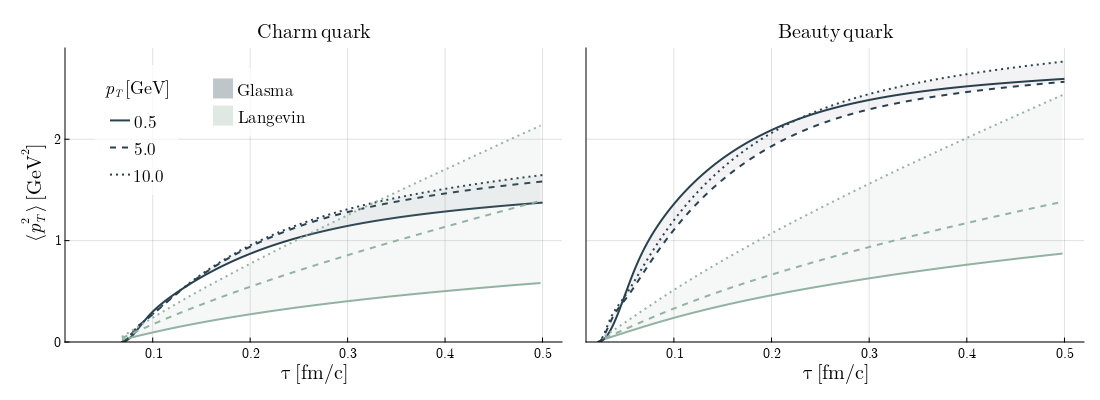

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000117afca0, 5500.0, 2000.0)


In [19]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[2], starrynight[6], starrynight[9]]
linestyles = [nothing, :dash, :dot]


fig = Figure(resolution = (1100, 400), font = "CMU Serif")
titles = [L"\mathrm{Charm\,quark}", L"\mathrm{Beauty\,quark}"]
axes = [Axis(fig[1,i], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle p_T^2\,\rangle\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, title=titles[i], titlesize=20) for i in 1:2]

for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = quarks[iq] * "_pT_" * string(pTs[ipT])
        if iq==1
            string_as_varname("linepT"*string(ipT), lines!(axes[iq], tau[tag], sigmapt_mean[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
        else
            lines!(axes[iq], tau[tag], sigmapt_mean[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT])
        end
        lines!(axes[iq], data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, ipT+1], linewidth = 2, color=colors[2], linestyle=linestyles[ipT])
        next_tag = quarks[iq] * "_pT_" * string(pTs[mod(ipT+1, 3)+1])
        string_as_varname("bandglasma"*string(ipT), band!(axes[iq], tau[tag], sigmapt_mean[tag], sigmapt_mean[next_tag]; color = (colors[1], 0.03)))
    end

    
    string_as_varname("bandlang"*string(iq), band!(axes[iq], data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, 2], data_lang_broad[quarks[iq]][:, 4]; color = (colors[2], 0.09)))
end

bands = [PolyElement(color = (colors[1], 0.3), strokecolor = :blue, strokewidth = 0), PolyElement(color = (colors[2], 0.3), strokecolor = :blue, strokewidth = 0)]
axislegend(axes[1], bands, [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.35, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))

axislegend(axes[1], [linepT1, linepT2, linepT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.05,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

ylims!(axes[1], 0, 2.9)
xlims!(axes[1], 0.01, 0.52)

linkaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false)

display(fig)
save("momentum_broadening_charm_vs_beauty_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

Derivative of momentum broadening for charm

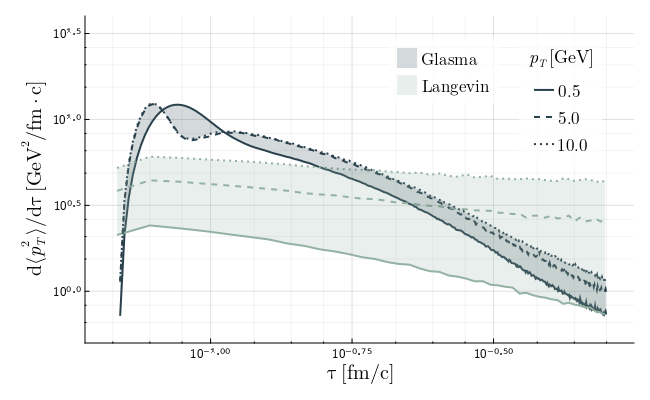

In [28]:
using ForwardDiff

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\mathrm{d}\langle p_T^2\,\rangle/\mathrm{d}\tau\,\mathrm{[GeV^2/fm\cdot c]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=13, yticklabelsize=13,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, 
        yscale=log10, xscale=log10,
        yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4),
        xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(4),
        xminortickalign = 1, xminorticksize=2, yminortickalign=1, yminorticksize=2
        ) 

iq = 1
dsigmapt = Dict()
for ipT in 1:length(pTs)
    tag_quark_pt = quarks[iq] * "_pT_" * string(pTs[ipT])
    dsigmapt[tag_quark_pt] = diff(sigmapt_mean[tag_quark_pt]) ./ diff(tau[tag_quark_pt])
    string_as_varname("lineglasmapT"*string(ipT), lines!(ax, tau[tag_quark_pt][2:length(tau[tag_quark_pt])], dsigmapt[tag_quark_pt], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
    string_as_varname("linelangpT"*string(ipT), lines!(ax, data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, ipT+4], linewidth = 2, color=colors[2], linestyle=linestyles[ipT]))
end

tag_quark_pt_first, tag_quark_pt_last = quarks[iq] * "_pT_" * string(pTs[1]), quarks[iq] * "_pT_" * string(pTs[3])
string_as_varname("bandglasma", band!(ax, tau[tag_quark_pt_first][2:length(tau[tag_quark_pt_first])], dsigmapt[tag_quark_pt_first], dsigmapt[tag_quark_pt_last]; color = (colors[1], 0.2)))
string_as_varname("bandlang", band!(ax, data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, 5], data_lang_broad[quarks[iq]][:, 7]; color = (colors[2], 0.2)))

axislegend(ax, [bandglasma, bandlang], [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.7, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [lineglasmapT1, lineglasmapT2, lineglasmapT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.95,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

ylims!(ax, 0.5, 40)
xlims!(ax, 0.06, 0.56)

display(fig)
# save("derivative_momentum_broadening_charm_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

Derivative of momentum broadening charm vs beauty

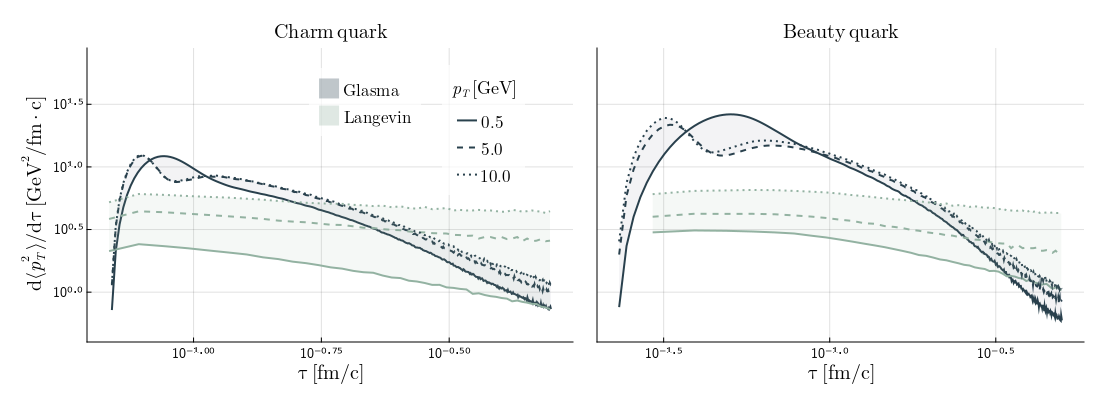

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000f3f3210, 5500.0, 2000.0)


In [38]:
using CairoMakie
using ColorSchemes
using ForwardDiff

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[2], starrynight[6], starrynight[9]]
linestyles = [nothing, :dash, :dot]

fig = Figure(resolution = (1100, 400), font = "CMU Serif")
titles = [L"\mathrm{Charm\,quark}", L"\mathrm{Beauty\,quark}"]
axes = [Axis(fig[1,i], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\mathrm{d}\langle p_T^2\,\rangle/\mathrm{d}\tau\,\mathrm{[GeV^2/fm\cdot c]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, title=titles[i], titlesize=20,
        yscale=log10, xscale=log10,
        # yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4),
        # xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(4),
        # xminortickalign = 1, xminorticksize=2, yminortickalign=1, yminorticksize=2
        ) for i in 1:2]

dsigmapt = Dict()
for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = quarks[iq] * "_pT_" * string(pTs[ipT])
        dsigmapt[tag] = diff(sigmapt_mean[tag]) ./ diff(tau[tag])
    end
end

for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = quarks[iq] * "_pT_" * string(pTs[ipT])
        if iq==1
            string_as_varname("linepT"*string(ipT), lines!(axes[iq], tau[tag][2:length(tau[tag])], dsigmapt[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
        else
            lines!(axes[iq], tau[tag][2:length(tau[tag])], dsigmapt[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT])
        end
        lines!(axes[iq], data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, ipT+4], linewidth = 2, color=colors[2], linestyle=linestyles[ipT])
        next_tag = quarks[iq] * "_pT_" * string(pTs[mod(ipT+1, 3)+1])
        string_as_varname("bandglasma"*string(ipT), band!(axes[iq], tau[tag][2:length(tau[tag])], dsigmapt[tag], dsigmapt[next_tag]; color = (colors[1], 0.03)))
    end

    
    string_as_varname("bandlang"*string(iq), band!(axes[iq], data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, 5], data_lang_broad[quarks[iq]][:, 7]; color = (colors[2], 0.09)))
end

bands = [PolyElement(color = (colors[1], 0.3), strokecolor = :blue, strokewidth = 0), PolyElement(color = (colors[2], 0.3), strokecolor = :blue, strokewidth = 0)]
axislegend(axes[1], bands, [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.6, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))

axislegend(axes[1], [linepT1, linepT2, linepT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.9,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

linkyaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false)
ylims!(axes[1], 0.4, 89)

display(fig)
save("derivative_momentum_broadening_charm_vs_beauty_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

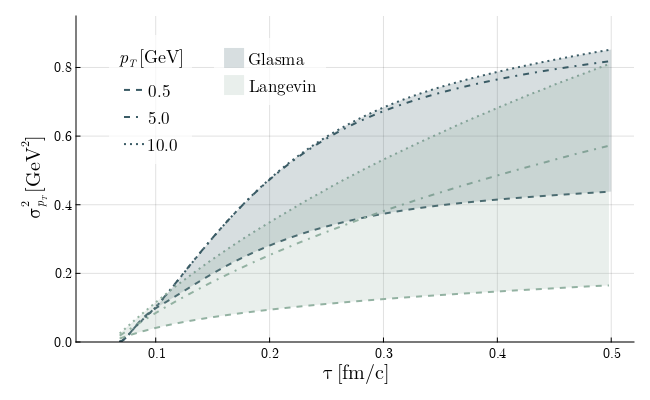

In [21]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\sigma^2_{p_T}\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

iq = 1
for ipT in 1:length(pTs)
    tag_quark_pt = quarks[iq] * "_pT_" * string(pTs[ipT])
    string_as_varname("lineglasmapT"*string(ipT), lines!(ax, tau[tag_quark_pt], sigmapt_std[tag_quark_pt], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
    string_as_varname("linelangpT"*string(ipT), lines!(ax, data_lang_sigmapt[quarks[iq]][:, 1], data_lang_sigmapt[quarks[iq]][:, ipT+7], linewidth = 2, color=colors[2], linestyle=linestyles[ipT]))
end

tag_quark_pt_first, tag_quark_pt_last = quarks[1] * "_pT_" * string(pTs[1]), quarks[iq] * "_pT_" * string(pTs[3])
string_as_varname("bandglasma", band!(ax, tau[tag_quark_pt_first], sigmapt_std[tag_quark_pt_first], sigmapt_std[tag_quark_pt_last]; color = (colors[1], 0.2)))
string_as_varname("bandlang", band!(ax, data_lang_sigmapt[quarks[iq]][:, 1], data_lang_sigmapt[quarks[iq]][:, 8], data_lang_sigmapt[quarks[iq]][:, 10]; color = (colors[2], 0.2)))

axislegend(ax, [bandglasma, bandlang], [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.3, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [lineglasmapT1, lineglasmapT2, lineglasmapT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.05,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

ylims!(ax, 0, 0.95)
xlims!(ax, 0.03, 0.52)

display(fig)
# save("standard_deviation_charm_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

Standard deviation in $p_T$ charm vs beauty

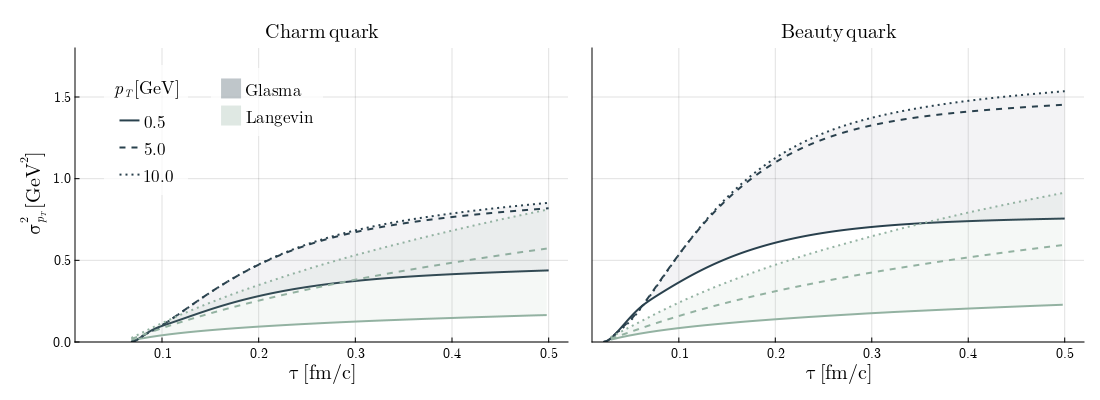

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000f6cb1a0, 5500.0, 2000.0)


In [26]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[2], starrynight[6], starrynight[9]]
linestyles = [nothing, :dash, :dot]


fig = Figure(resolution = (1100, 400), font = "CMU Serif")
titles = [L"\mathrm{Charm\,quark}", L"\mathrm{Beauty\,quark}"]
axes = [Axis(fig[1,i], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\sigma^2_{p_T}\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, title=titles[i], titlesize=20) for i in 1:2]

for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = quarks[iq] * "_pT_" * string(pTs[ipT])
        if iq==1
            string_as_varname("linepT"*string(ipT), lines!(axes[iq], tau[tag], sigmapt_std[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
        else
            lines!(axes[iq], tau[tag], sigmapt_std[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT])
        end
        lines!(axes[iq], data_lang_sigmapt[quarks[iq]][:, 1], data_lang_sigmapt[quarks[iq]][:, ipT+7], linewidth = 2, color=colors[2], linestyle=linestyles[ipT])
        next_tag = quarks[iq] * "_pT_" * string(pTs[mod(ipT+1, 3)+1])
        string_as_varname("bandglasma"*string(ipT), band!(axes[iq], tau[tag], sigmapt_std[tag], sigmapt_std[next_tag]; color = (colors[1], 0.03)))
    end

    string_as_varname("bandlang"*string(iq), band!(axes[iq], data_lang_sigmapt[quarks[iq]][:, 1], data_lang_sigmapt[quarks[iq]][:, 8], data_lang_sigmapt[quarks[iq]][:, 10]; color = (colors[2], 0.09)))
end

bands = [PolyElement(color = (colors[1], 0.3), strokecolor = :blue, strokewidth = 0), PolyElement(color = (colors[2], 0.3), strokecolor = :blue, strokewidth = 0)]
axislegend(axes[1], bands, [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.35, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))

axislegend(axes[1], [linepT1, linepT2, linepT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.05,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

linkaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false)

ylims!(axes[1], 0, 1.8)
xlims!(axes[1], 0.01, 0.52)

display(fig)
save("standard_deviation_charm_vs_beauty_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

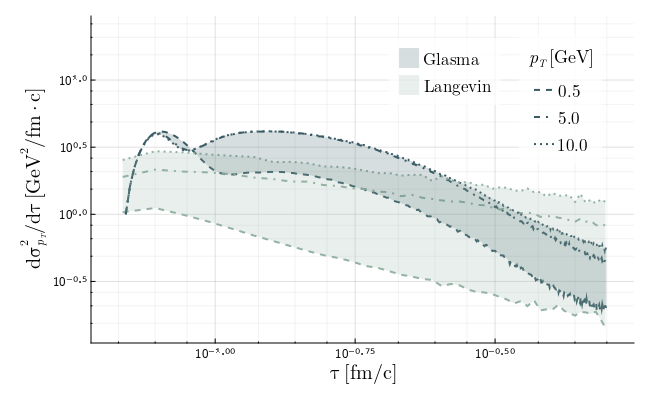

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000ec0cce0, 3250.0, 2000.0)


In [8]:
using ForwardDiff

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\mathrm{d}\sigma_{p_T}^2/\mathrm{d}\tau\,\mathrm{[GeV^2/fm\cdot c]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=13, yticklabelsize=13,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, 
        yscale=log10, xscale=log10,
        yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4),
        xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(4),
        xminortickalign = 1, xminorticksize=2, yminortickalign=1, yminorticksize=2
        ) 

dsigmapt = Dict()
for ipT in 1:length(pTs)
    tag_quark_pt = quarks[1] * "_pT_" * string(pTs[ipT])
    dsigmapt[tag_quark_pt] = diff(sigmapt_std[tag_quark_pt]) ./ diff(tau[tag_quark_pt])
    string_as_varname("lineglasmapT"*string(ipT), lines!(ax, tau[tag_quark_pt][2:length(tau[tag_quark_pt])], dsigmapt[tag_quark_pt], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
    string_as_varname("linelangpT"*string(ipT), lines!(ax, data_lang_sigmapt[:, 1], data_lang_sigmapt[:, ipT+10], linewidth = 2, color=colors[2], linestyle=linestyles[ipT]))
end

tag_quark_pt_first, tag_quark_pt_last = quarks[1] * "_pT_" * string(pTs[1]), quarks[1] * "_pT_" * string(pTs[3])
string_as_varname("bandglasma", band!(ax, tau[tag_quark_pt_first][2:length(tau[tag_quark_pt_first])], dsigmapt[tag_quark_pt_first], dsigmapt[tag_quark_pt_last]; color = (colors[1], 0.2)))
string_as_varname("bandlang", band!(ax, data_lang_sigmapt[:, 1], data_lang_sigmapt[:, 11], data_lang_sigmapt[:, 13]; color = (colors[2], 0.2)))

axislegend(ax, [bandglasma, bandlang], [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.7, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [lineglasmapT1, lineglasmapT2, lineglasmapT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.95,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

ylims!(ax, 0.11, 30)
xlims!(ax, 0.06, 0.56)

display(fig)
save("derivative_standard_deviation_charm_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

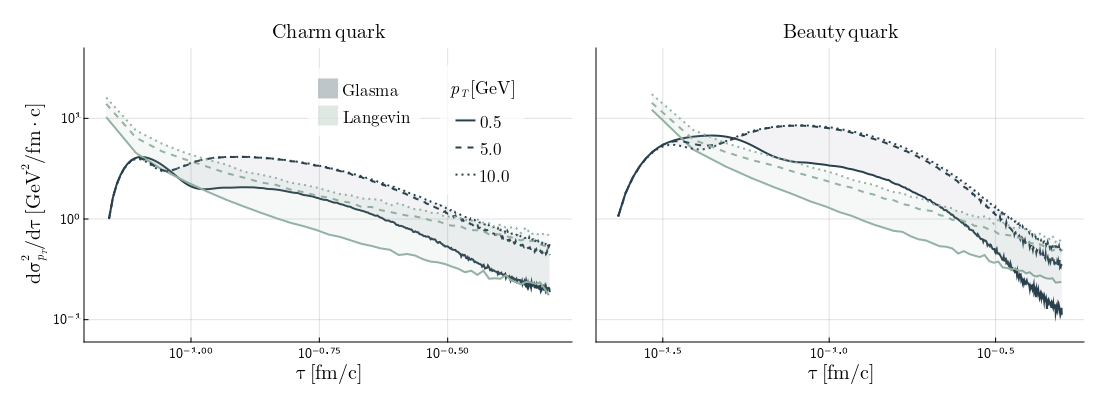

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x0000000010ee6d90, 5500.0, 2000.0)


In [37]:
using CairoMakie
using ColorSchemes
using ForwardDiff

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[2], starrynight[6], starrynight[9]]
linestyles = [nothing, :dash, :dot]

fig = Figure(resolution = (1100, 400), font = "CMU Serif")
titles = [L"\mathrm{Charm\,quark}", L"\mathrm{Beauty\,quark}"]
axes = [Axis(fig[1,i], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\mathrm{d}\sigma_{p_T}^2/\mathrm{d}\tau\,\mathrm{[GeV^2/fm\cdot c]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, title=titles[i], titlesize=20,
        yscale=log10, xscale=log10,
        # yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4),
        # xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(4),
        # xminortickalign = 1, xminorticksize=2, yminortickalign=1, yminorticksize=2
        ) for i in 1:2]

dsigmapt = Dict()
for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = quarks[iq] * "_pT_" * string(pTs[ipT])
        dsigmapt[tag] = diff(sigmapt_std[tag]) ./ diff(tau[tag])
    end
end

for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = quarks[iq] * "_pT_" * string(pTs[ipT])
        if iq==1
            string_as_varname("linepT"*string(ipT), lines!(axes[iq], tau[tag][2:length(tau[tag])], dsigmapt[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT]))
        else
            lines!(axes[iq], tau[tag][2:length(tau[tag])], dsigmapt[tag], linewidth = 2, color=colors[1], linestyle=linestyles[ipT])
        end
        lines!(axes[iq], data_lang_sigmapt[quarks[iq]][:, 1], data_lang_sigmapt[quarks[iq]][:, ipT+4], linewidth = 2, color=colors[2], linestyle=linestyles[ipT])
        next_tag = quarks[iq] * "_pT_" * string(pTs[mod(ipT+1, 3)+1])
        string_as_varname("bandglasma"*string(ipT), band!(axes[iq], tau[tag][2:length(tau[tag])], dsigmapt[tag], dsigmapt[next_tag]; color = (colors[1], 0.03)))
    end

    
    string_as_varname("bandlang"*string(iq), band!(axes[iq], data_lang_sigmapt[quarks[iq]][:, 1], data_lang_sigmapt[quarks[iq]][:, 5], data_lang_sigmapt[quarks[iq]][:, 7]; color = (colors[2], 0.09)))
end

bands = [PolyElement(color = (colors[1], 0.3), strokecolor = :blue, strokewidth = 0), PolyElement(color = (colors[2], 0.3), strokecolor = :blue, strokewidth = 0)]
axislegend(axes[1], bands, [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.6, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))

axislegend(axes[1], [linepT1, linepT2, linepT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.9,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

linkyaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false)
ylims!(axes[1], 0.06, 50)

display(fig)
save("derivative_standard_deviation_charm_vs_beauty_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

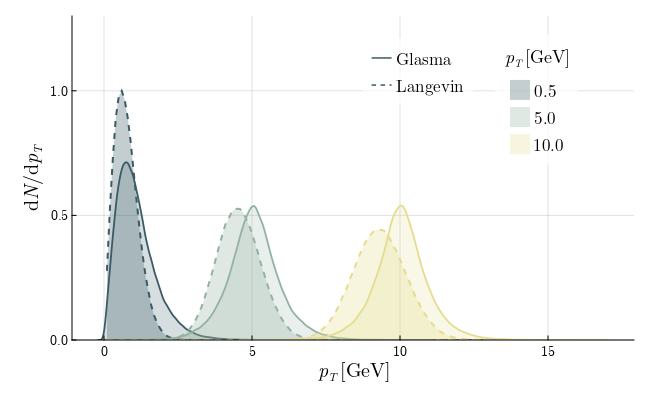

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000ff69b90, 3250.0, 2000.0)


In [9]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"p_T\,\mathrm{[GeV]}", ylabel=L"\mathrm{d}N/\mathrm{d}p_T",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

for ipT in 1:length(pTs)
    tag_quark_pt = quarks[1] * "_pT_" * string(pTs[ipT])
    string_as_varname("histglasmapT"*string(ipT), density!(ax, pts[tag_quark_pt][1], color =(colors[ipT], 0.2), strokecolor=colors[ipT], strokewidth=1.8))
    string_as_varname("histlangpT"*string(ipT), lines!(ax, Float64.(data_lang_distrib[:, 1]), Float64.(data_lang_distrib[:, ipT+1]), linewidth = 2, color=colors[ipT], linestyle=:dash))
    string_as_varname("bandlangpT"*string(ipT), band!(ax, Float64.(data_lang_distrib[:, 1]), zeros(length(data_lang_distrib[:, ipT+1])), Float64.(data_lang_distrib[:, ipT+1]); color = (colors[ipT], 0.3)))
end

lines_legend = [LineElement(color = colors[1], strokecolor = :transparent), LineElement(color = colors[1], strokecolor = :transparent, linestyle=:dash)]
axislegend(ax, lines_legend, [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.65, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [bandlangpT1, bandlangpT2, bandlangpT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.9,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

ylims!(ax, 0, 1.3)

display(fig)
save("pT_spectrum_charm_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

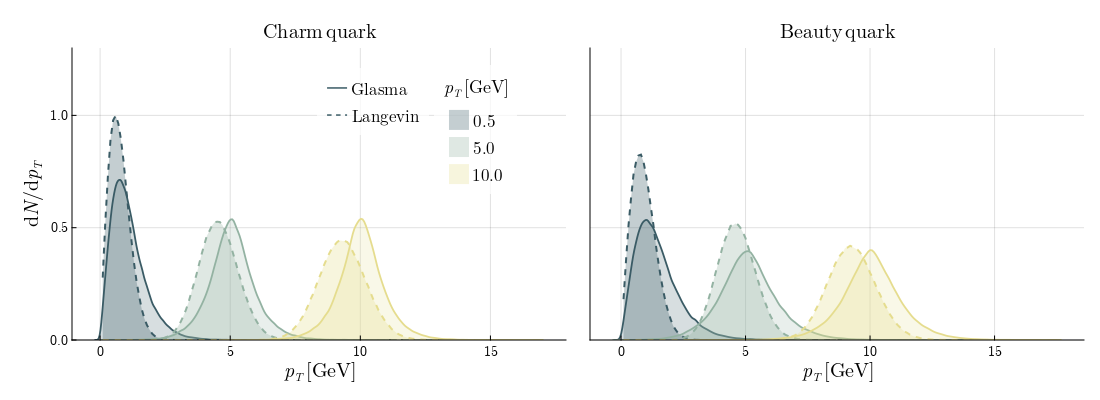

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000f4db780, 5500.0, 2000.0)


In [51]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]

fig = Figure(resolution = (1100, 400), font = "CMU Serif")

titles = [L"\mathrm{Charm\,quark}", L"\mathrm{Beauty\,quark}"]
axes = [Axis(fig[1,i], xlabel=L"p_T\,\mathrm{[GeV]}", ylabel=L"\mathrm{d}N/\mathrm{d}p_T",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, title=titles[i], titlesize=20) for i in 1:2]

for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag_quark_pt = quarks[iq] * "_pT_" * string(pTs[ipT])
        string_as_varname("histglasmapT"*string(ipT), density!(axes[iq], pts[tag_quark_pt][1], color =(colors[ipT], 0.2), strokecolor=colors[ipT], strokewidth=1.8))
        string_as_varname("histlangpT"*string(ipT), lines!(axes[iq], Float64.(data_lang_distrib[quarks[iq]][:, 1]), Float64.(data_lang_distrib[quarks[iq]][:, ipT+1]), linewidth = 2, color=colors[ipT], linestyle=:dash))
        string_as_varname("bandlangpT"*string(ipT), band!(axes[iq], Float64.(data_lang_distrib[quarks[iq]][:, 1]), zeros(length(data_lang_distrib[quarks[iq]][:, ipT+1])), Float64.(data_lang_distrib[quarks[iq]][:, ipT+1]); color = (colors[ipT], 0.3)))
    end
end

lines_legend = [LineElement(color = colors[1], strokecolor = :transparent), LineElement(color = colors[1], strokecolor = :transparent, linestyle=:dash)]
axislegend(axes[1], lines_legend, [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=17, 
    position = (0.65, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(axes[1], [bandlangpT1, bandlangpT2, bandlangpT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=18, position = (0.9,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

linkyaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false)
ylims!(axes[1], 0, 1.3)

display(fig)
save("pT_spectrum_charm_vs_beauty_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

Plot momentum variance for Glasma and Langevin.

In [ ]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
from scipy import signal 

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{Glasma\,vs.\,Langevin}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 20)

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

ax.set_xlim(0, 0.5)
ax.set_ylim(0, 6.0)

tags = ['charm_pT_0.5', 'charm_pT_5.0', 'charm_pT_10.0']
colors = ['#A3BE8C', '#B48EAD', '#88C0D0']
labels = [r'$0.5$', r'$5.0$', r'$10.0$']
i=0
results = pickle.load(open('sigmapt.pickle', 'rb'))
plot_lines = []

taus = {}
for tag in tags:
    # p = results['parameters'][tag]

    a = L/N
    DT = 1.0 / DTS
    maxt = int(tau_s / a * DTS)
    formt = int(p['TFORM'] / a * DTS)
    # taus[tag] = np.linspace(p['TFORM'], tau_s, maxt-formt+1)

    ax.plot(results['tau'][tag], results['sigmapt_mean'][tag], color=colors[i], linewidth=2.5)
    i += 1

data_lang = np.loadtxt('langevin2.dat')
tau_lang = data_lang[:, 0]

i = 0

for tag in tags:
    sigmapt_lang = data_lang[:, i+1]
    ax.plot(tau_lang, sigmapt_lang, color=colors[i], linewidth=2.5, linestyle='-.')
    i = i+1

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,1,2]], labels, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.77), title=r'$p_T\,\mathrm{[GeV]}$')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend2 = plt.legend([lines[i] for i in [2,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper right', bbox_to_anchor=(0.97,0.97))
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
ax.add_artist(legend1)
ax.add_artist(legend2)

left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
axin = fig.add_axes([0.22, 0.48, 0.37, 0.37])

i = 0
for tag in tags:
    derivative = np.diff(results['sigmapt_mean'][tag]) / np.diff(results['tau'][tag])
    # axin.plot(taus[tag][1:len(taus[tag])], derivative, color=colors[i], linewidth=1.5)
    axin.plot(results['tau'][tag][1:len(results['tau'][tag])], signal.savgol_filter(derivative, 51, 10), color=colors[i], linewidth=1.5)
    
    axin.plot(tau_lang, data_lang[:, i+4], color=colors[i], linewidth=1.5, linestyle='-.')
    i += 1

axin.spines['top'].set_color('silver')
axin.spines['right'].set_color('silver')
axin.spines['bottom'].set_color('gray')
axin.spines['left'].set_color('gray') 
axin.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)

axin.set_xlabel(r'$\tau$', size = 16)
axin.set_ylabel(r'$\mathrm{d}\sigma_{p_T}/\mathrm{d}\tau$', size = 16)
axin.tick_params(axis='both', which='major', labelsize=12)

formatter = ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((0,2))
axin.yaxis.set_major_formatter(formatter)
t = axin.yaxis.get_offset_text()
t.set_size(12)

# axin.set_xlim(0, 0.5)
# axin.set_ylim(0, 17)
# axin.yaxis.set_major_locator(MultipleLocator(5))
# axin.xaxis.set_major_locator(MultipleLocator(0.1))
# axin.yaxis.get_major_ticks()[1].label1.set_visible(False)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.yaxis.set_major_locator(MultipleLocator(1.6))
ax.yaxis.set_minor_locator(MultipleLocator(0.8))

axin.set_xscale('log')
axin.set_yscale('log')
axin.set_xlim(0.05, 0.45)
axin.set_ylim(0.5, 50.0)
axin.xaxis.grid(True, which='minor')
axin.yaxis.grid(True, which='minor')
plt.setp(axin.get_xminorticklabels(), visible=False)
axin.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
axin.grid(b=True, which='minor', color='silver', alpha=0.2)

# plt.savefig('sigmapt_charm_comp_glasma_langevin.png', dpi=300, facecolor='white', transparent=False)
# plt.savefig('sigmapt_charm_comp_glasma_langevin_logloginset.png', dpi=300, facecolor='white', transparent=False)

Plot transverse momentum distribution for Glasma and Langevin at $\tau=0.5\,\mathrm{fm/c}$.

In [ ]:
from scipy.interpolate import interp1d

fig = plt.figure()
ax = plt.subplot()
plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\tau=0.5\,\mathrm{fm/c}$', size = 18)
plt.xlabel(r'$p_T\,\mathrm{[GeV]}$', size = 20)
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}p_T$', size = 20)

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

results = pickle.load(open('sigmapt.pickle', 'rb'))
data_lang = np.loadtxt('langevin3.dat')
tau_lang = data_lang[:, 0]

i = 0
for tag in tags:
    n, bins, _ = ax.hist(results['pts'][tag], bins=50, density=True, alpha=0.2, color=colors[i])  
    bin_centers = 0.5*(bins[1:]+bins[:-1])

    bin_interp = np.linspace(bin_centers[0], bin_centers[len(bin_centers)-1], 100)
    cubic_interp = interp1d(bin_centers, n, kind='cubic')
    cubic_results = cubic_interp(bin_interp)
    ax.plot(bin_interp, cubic_results, color=colors[i], linewidth = 2.0, alpha=1.0, label=labels[i])

    total = ntp * nevents
    plt.hist(np.ones(total)*results['parameters'][tag]['PT'], bins=7, density=True, alpha=0.6, color=colors[i])

    ax.plot(tau_lang, data_lang[:, i+1], color=colors[i], linewidth=2.0, linestyle='-.')
    i += 1

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,2,4]], labels, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.77), title=r'$p_T\,\mathrm{[GeV]}$')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend2 = plt.legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper right', bbox_to_anchor=(0.97,0.97))
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
ax.add_artist(legend1)
ax.add_artist(legend2)

ax.set_xlim(0, 15)
ax.set_ylim(0, 3)
ax.yaxis.set_major_locator(MultipleLocator(0.8))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(3))
ax.xaxis.set_minor_locator(MultipleLocator(1.5))

# plt.savefig('dndpt_charm_glasma_langevin.png', dpi=300, facecolor='white', transparent=False)

Plot standard deviation in transverse momentum distribution for Glasma and Langevin.

In [ ]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.ticker import ScalarFormatter
from scipy import signal 

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{Glasma\,vs.\,Langevin}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\mathrm{d}\sigma_{p_T}/\mathrm{d}\tau$', size = 20)

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

ax.set_xlim(0, 0.5)
ax.set_ylim(0, 6.0)

tags = ['charm_pT_0.5', 'charm_pT_5.0', 'charm_pT_10.0']
colors = ['#A3BE8C', '#B48EAD', '#88C0D0']
labels = [r'$0.5$', r'$5.0$', r'$10.0$']
i=0
results = pickle.load(open('sigmapt.pickle', 'rb'))
plot_lines = []

taus = {}
for tag in tags:
    p = results['parameters'][tag]

    # a = p['L'] / p['N']
    # DT = 1.0 / p['DTS']
    # maxt = int(p['TMAX'] / a * DTS)
    # formt = int(p['TFORM'] / a * p['DTS'])
    # taus[tag] = np.linspace(p['TFORM'], p['TMAX'], maxt-formt+1)

    ax.plot(results['tau'][tag], results['sigmapt_mean'][tag], color=colors[i], linewidth=2.5)
    i += 1

data_lang = np.loadtxt('langevin1.dat')
tau_lang = data_lang[:, 0]

i = 0

for tag in tags:
    sigmapt_lang = data_lang[:, i+1]
    ax.plot(tau_lang, sigmapt_lang, color=colors[i], linewidth=2.5, linestyle='-.')
    i = i+1

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,1,2]], labels, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.77), title=r'$p_T\,\mathrm{[GeV]}$')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend2 = plt.legend([lines[i] for i in [2,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper right', bbox_to_anchor=(0.97,0.97))
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
ax.add_artist(legend1)
ax.add_artist(legend2)

left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
axin = fig.add_axes([0.22, 0.48, 0.37, 0.37])

i = 0
for tag in tags:
    derivative = np.diff(results['sigmapt_mean'][tag]) / np.diff(results['tau'][tag])
    # axin.plot(taus[tag][1:len(taus[tag])], derivative, color=colors[i], linewidth=1.5)
    axin.plot(results['tau'][tag][1:len(results['tau'][tag])], signal.savgol_filter(derivative, 51, 10), color=colors[i], linewidth=1.5)
    axin.plot(tau_lang, data_lang[:, i+4], color=colors[i], linewidth=1.5, linestyle='-.')
    i += 1

axin.spines['top'].set_color('silver')
axin.spines['right'].set_color('silver')
axin.spines['bottom'].set_color('gray')
axin.spines['left'].set_color('gray') 
axin.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)

axin.set_xlabel(r'$\tau$', size = 16)
axin.set_ylabel(r'$\mathrm{d}\sigma_{p_T}/\mathrm{d}\tau$', size = 16)
axin.tick_params(axis='both', which='major', labelsize=12)

formatter = ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((0,2))
axin.yaxis.set_major_formatter(formatter)
t = axin.yaxis.get_offset_text()
t.set_size(12)

# axin.set_xlim(0, 0.5)
# axin.set_ylim(0, 17)
# axin.yaxis.set_major_locator(MultipleLocator(5))
# axin.xaxis.set_major_locator(MultipleLocator(0.1))
# axin.yaxis.get_major_ticks()[1].label1.set_visible(False)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.yaxis.set_major_locator(MultipleLocator(1.6))
ax.yaxis.set_minor_locator(MultipleLocator(0.8))

# plt.savefig('sigmapt_dndpt_charm_comp_glasma_langevin.png', dpi=300, facecolor='white', transparent=False)

axin.set_xscale('log')
axin.set_yscale('log')
axin.set_xlim(0.05, 0.5)
axin.set_ylim(0.07, 50.0)
axin.xaxis.grid(True, which='minor')
axin.yaxis.grid(True, which='minor')
plt.setp(axin.get_xminorticklabels(), visible=False)
axin.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
axin.grid(b=True, which='minor', color='silver', alpha=0.2)

# plt.savefig('sigmapt_dndpt_charm_comp_glasma_langevin_logloginset.png', dpi=300, facecolor='white', transparent=False)

In [ ]:
## Read data from files using Julia
using Pickle
using DelimitedFiles

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

file = "hqs+glasma_charm+beauty.pickle"
data_glasma = Pickle.npyload(file)
parameters = data_glasma["parameters"]
obs = data_glasma["obs"]
quarks, pTs, tags = data_glasma["quarks"], data_glasma["pTs"], data_glasma["tags"]
tau, mom_broads, pts, pts_final, std_pt = obs["tau"], obs["mom_broad"], obs["pts"], obs["pts_final"], obs["std_pt"]


data_lang_broad, data_lang_sigmapt, data_lang_distrib = Dict(), Dict(), Dict()
for quark in quarks
    data_lang_broad[quark], header = readdlm("langevin_"*quark*"_broadening.dat", header=true)
    data_lang_sigmapt[quark], header = readdlm("langevin_"*quark*"_sigmapt.dat", header=true)
    data_lang_distrib[quark], header = readdlm("langevin_"*quark*"_distrib.dat", header=true)
end
## Plots of transverse momentum broadening
Momentum broadening $\langle p_T^2\rangle$ Glasma vs. Langevin for charm and beauty quarks.
using CairoMakie
using ColorSchemes

colormap = cgrad(:beach, 11, categorical = true)
colors = [colormap[3], colormap[6], colormap[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1000, 400), font = "CMU Serif")
# titles = [L"\mathrm{Charm\,quark}", L"\mathrm{Beauty\,quark}"]
axes = [Axis(fig[1,i], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\Delta p_T^2\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) for i in 1:2]

for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = "toy_" * quarks[iq] * "_pT_" * string(pTs[ipT])
        mom_broad_T = (mom_broads[tag][:, 1] + mom_broads[tag][:, 2])/3
        string_as_varname("lang_pT"*string(ipT), lines!(axes[iq], data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, ipT+1], linewidth = 2.5, color=colors[ipT], linestyle=:dashdot))
        string_as_varname("wong_pT"*string(ipT), lines!(axes[iq], tau[quarks[iq]][:], mom_broad_T, linewidth = 2.5, color=colors[ipT]))
    end   
end

axislegend(axes[1], [wong_pT3, lang_pT3], [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=18, 
    position = (0.35, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))

axislegend(axes[1], [wong_pT1, wong_pT2, wong_pT3], 
    [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
    labelsize=17, titlesize=19, position = (0.05,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

ylims!(axes[1], 0, 3.3)
xlims!(axes[1], 0.01, 0.52)
xlims!(axes[2], 0.01, 0.52)

text!(axes[1], L"\mathrm{Charm\,quark}", position = (0.37, 2.75), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")
text!(axes[1], L"\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.335, 2.45), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")
text!(axes[2], L"\mathrm{Beauty\,quark}", position = (0.04,2.75), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")
text!(axes[2], L"\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.04, 2.45), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")

linkyaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false)

display(fig)
save("transverse_momentum_broadening_charm+beauty_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 
Proper time derivative of momentum broadening $\mathrm{d}\Delta p_T^2/\mathrm{d}\tau$
using CairoMakie
using ColorSchemes
using ForwardDiff
using UnicodeFun

colormap = cgrad(:beach, 11, categorical = true)
colors = [colormap[3], colormap[6], colormap[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (900, 400), font = "CMU Serif")
# titles = [L"\mathrm{Charm\,quark}", L"\mathrm{Beauty\,quark}"]
axes = [Axis(fig[1,i], xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\mathrm{d}\Delta p_T^2/\mathrm{d}\tau\,\mathrm{[GeV^2/fm\cdot c]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 18, ylabelsize= 18, xticklabelsize=12, yticklabelsize=12,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, 
        yscale=log10, yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(8), yminortickalign=1, yminorticksize=2,
        #  xscale=log10, xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(8), xminortickalign = 1, xminorticksize=2, 
        ) for i in 1:2]

for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag = "toy_" * quarks[iq] * "_pT_" * string(pTs[ipT])
        mom_broad_T = (mom_broads[tag][:, 1] + mom_broads[tag][:, 2])/3
        dmom_broad = diff(mom_broad_T) ./ diff(tau[quarks[iq]])
        string_as_varname("lang_pT"*string(ipT), lines!(axes[iq], data_lang_broad[quarks[iq]][:, 1], data_lang_broad[quarks[iq]][:, ipT+4], linewidth = 2, color=colors[ipT], linestyle=:dashdot))
        string_as_varname("wong_pT"*string(ipT), lines!(axes[iq], tau[quarks[iq]][2:length(tau[quarks[iq]])], dmom_broad, linewidth = 2, color=colors[ipT]))
    end   
end

# axislegend(axes[1], [wong_pT3, lang_pT3], [L"\mathrm{Glasma}", L"\mathrm{Langevin}"],  labelsize=18, 
#     position = (0.35, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))

# axislegend(axes[1], [wong_pT1, wong_pT2, wong_pT3], 
#     [L"0.5", L"5.0", L"10.0"], L"p_T\,\mathrm{[GeV]}",
#     labelsize=17, titlesize=19, position = (0.05,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

# ylims!(axes[1], 0, 3.3)
# xlims!(axes[1], 0.01, 0.52)
# xlims!(axes[2], 0.01, 0.52)

# text!(axes[1], L"\mathrm{Charm\,quark}", position = (0.37, 2.75), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")
# text!(axes[1], L"\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.335, 2.45), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")
# text!(axes[2], L"\mathrm{Beauty\,quark}", position = (0.04,2.75), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")
# text!(axes[2], L"\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.04, 2.45), bgcolor = (:white, 0.7), textsize=17, color="#8a8a8a")

linkyaxes!(axes[1], axes[2])
hideydecorations!(axes[2], grid = false, minorgrid=false)

for axi in 1:2
    axes[axi].yticks = 10 .^ [0.0, 1.0]
    axes[axi].ytickformat = data -> [to_latex(raw"10^{".*string.(trunc(Int, log10(y))).*"}") for y in data]
    # axes[axi].xticks = 10 .^ [-1.0]
    # axes[axi].xtickformat = data -> [to_latex(raw"10^{".*string.(trunc(Int, log10(y))).*"}") for y in data]
    # xlims!(axes[axi], 0.01, 0.52)
end

display(fig)
# save("nonono.png", fig, px_per_unit = 5.0) 
using CairoMakie
using UnicodeFun

data = LinRange(0.01, 0.99, 200)
f = Figure(resolution = (400, 400), font="CMU Serif")

ax = Axis(f[1,1], yscale=log10,
        yminorticksvisible = true, yminorgridvisible = true,
        yminorticks = IntervalsBetween(8))

lines!(ax, data, color = :blue)

@which ax.yticks = 10 .^ [-2.0, -1.0, 0.0]
ax.ytickformat = data -> [to_latex(raw"10^{".*string.(trunc(Int, log10(y))).*"}") for y in data]

display(f)
@which ax.yticks = 10 .^ [-2.0, -1.0, 0.0]

In [2]:
using CairoMakie
using Colors

starrynight = cgrad(:beach, 6, categorical = true)
colors = [starrynight[i] for i in 1:6]
hex.(colors)

6-element Vector{String}:
 "FFDA8042"
 "FFE2AB4A"
 "FFE1C45E"
 "FFC8C198"
 "FFBBC0E1"
 "FFFFFFFF"